In [1]:
!git clone https://github.com/abhidya/jokes.git

fatal: destination path 'jokes' already exists and is not an empty directory.


In [2]:
! python3 -m textblob.download_corpora


[nltk_data] Downloading package brown to
[nltk_data]     /Users/mannybhidya/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mannybhidya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mannybhidya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mannybhidya/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/mannybhidya/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/mannybhidya/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [3]:
import random
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from math import isnan
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np
pd.set_option('display.max_columns', 155)  
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from sklearn.feature_extraction.text import CountVectorizer
import xgboost

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mannybhidya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
## IF using Google Colab

df = pd.read_csv("/content/jokes/train_final.csv")
submission = pd.read_csv("/content/jokes/test_final.csv")
jokes = pd.read_csv("/content/jokes/jester_items.csv")


## If using kaggle kernel
# df = pd.read_csv("../input/utkml/train_final.csv")
# submission = pd.read_csv("../input/utkml/test_final.csv")
# jokes = pd.read_csv("../input/utkml/jester_items.csv")

# IF running locally from the github repo
#df = pd.read_csv("train_final.csv")
#submission = pd.read_csv("test_final.csv")
#jokes = pd.read_csv("jester_items.csv")

# NLP EDA:  Exploratory Data Analysis


In [6]:
configure_plotly_browser_state()

jokes['jokeText'].apply(lambda x: len(x)).iplot(
    kind='hist',
    bins=100,
    xTitle='jokeText length',
    linecolor='black',
    yTitle='count',
    title='Text Length Distribution')

In [7]:
configure_plotly_browser_state()

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(jokes['jokeText'], 20)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in Jokes before removing stop words')


In [8]:
configure_plotly_browser_state()


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(jokes['jokeText'], 20)
# for word, freq in common_words:
#     print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in Jokes after removing stop words')

In [9]:
configure_plotly_browser_state()


def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(jokes['jokeText'], 20)
df3 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df3.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in Jokes before removing stop words')

In [10]:
configure_plotly_browser_state()


def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(jokes['jokeText'], 20)
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in Jokes after removing stop words')


In [11]:


configure_plotly_browser_state()


def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(jokes['jokeText'], 20)
df5 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df5.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in Jokes before removing stop words')


In [12]:
configure_plotly_browser_state()


def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(jokes['jokeText'], 20)
df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df6.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in Jokes after removing stop words')


[*Part-Of-Speech Tagging (POS)*](https://en.wikipedia.org/wiki/Part-of-speech_tagging)is a process of assigning parts of speech to each word, such as noun, verb, adjective, etc

We use a simple [*TextBlob*](https://textblob.readthedocs.io/en/dev/) API to dive into POS of our "Review Text" feature in our data set, and visualize these tags.

In [13]:
configure_plotly_browser_state()

from textblob import TextBlob

blob = TextBlob(str(jokes['jokeText']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 20 Part-of-speech tagging for review corpus')

Topic Modeling Review Text
==========================

Finally, we want to explore topic modeling algorithm to this data set, to see whether it would provide any benefit, and fit with what we are doing for our review text feature.

We will experiment with Latent Semantic Analysis (LSA) technique in topic modeling.

-   Generating our document-term matrix from review text to a matrix of [TF-IDF features](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).
-   LSA model replaces raw counts in the document-term matrix with a TF-IDF score.
-   Perform dimensionality reduction on the document-term matrix using [truncated SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
-   Because the number of department is 6, we set `n_topics=6`.
-   Taking the `argmax` of each review text in this topic matrix will give the predicted topics of each review text in the data. We can then sort these into counts of each topic.
-   To better understand each topic, we will find the most frequent three words in each topic.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from collections import Counter

reindexed_data = jokes['jokeText']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
    
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
#                 print(topic, keys[i], i, )
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)

    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

top_n_words_lsa = get_top_n_words(10, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  man said says difference time doctor woman father replied room
Topic 2:  does bulb light lightbulb screw change funny darwin men takes
Topic 3:  engineer mechanical engineers just said electrical mickey run mile shoes
Topic 4:  work shredder 00 station new taking stops bus copies feeding
Topic 5:  says person did walks bartender hear make 10 long bar
Topic 6:  school slash opposite mother phones teacher chukcha jones book guy


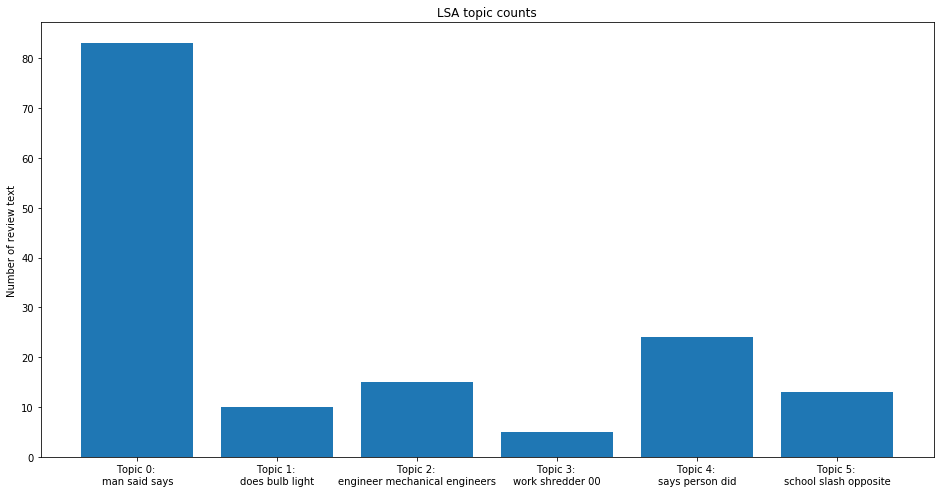

In [15]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts');
plt.show();

# Feature Engineering


#  Solutions

### Building training and validation set

Here We use the function split_df_x_y, it takes a dataframe, returns a dataframe and list. The list returned contains the highest rated joke for every user it also replaces the rating for the top rated joke with NaN.


we will take the df create a **train** and a **test** by using sklearn's *train_test_split* method, 

we will then use *split_df_x_y* to create **train, train_y** and **test, test_y**

#### The Goal?

we want an algorithm that when given **train** it returns train_y

We can test how accurate we are by giving our developed/trained algorithm **test** and comparing its output with **test_y**, We can assume this is accurate since our algorithm hasnt seen the data in test yet

In [16]:
def split_df_x_y(df):  #takes a dataframe, returns a dataframe and list. 
    """
    The list returned contains the highest rated joke for every user
    it also replaces the rating for the top rated joke with NaN
    """
    df_y = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        user_id = index
        favorite_joke = row[1:].idxmax(axis=0)
        df.loc[user_id, favorite_joke] = float('nan')
        df_y.append(favorite_joke)
    return df, df_y


temp_df = df.copy(deep=True)
train, test = train_test_split(temp_df, random_state=2020)



train, train_y = split_df_x_y(train)

test, test_y = split_df_x_y(test)


## Simple Solution

We will Predict based on the best joke  the user has not seen. 

### What is the "best" joke?

We get this by finding the mean joke rating and sorting from Greatest to Least

IMDB Weighted Rating Formula
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Another technique could be IMDB's *weighted rating* formula which is mathematically represented as follows:

Weighted Rating (WR) = ![$(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$](https://render.githubusercontent.com/render/math?math=%28%5Cfrac%7Bv%7D%7Bv%20%2B%20m%7D%20.%20R%29%20%2B%20%28%5Cfrac%7Bm%7D%7Bv%20%2B%20m%7D%20.%20C%29&mode=inline)

where,

-   *v* is the number of votes for the movie
-   *m* is the minimum votes required to be listed in the chart
-   *R* is the average rating of the movie
-   *C* is the mean vote across the whole report

The next step is to determine an appropriate value for *m*, the minimum votes required to be listed in the chart. We will use **95th percentile** as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [17]:
def IMDB_Weighted_Formula (df, col):
    v = df[col].count()
    m = 200
    R = df[col].mean()
    C = [val for val in df.drop(["user_id"], axis=1).mean() ]
    C = sum(C)/len(C)    
    value = ((v/(v+m))*(R))+((m/(v+m))*C)
    return value

IMDB_Weighted_Formula(df, "JOKE:7")

-1.7726768777754731

In [18]:
df.columns

for i in sorted(df.columns[1:], key=lambda x: IMDB_Weighted_Formula(df, x), reverse=True):
    print(i, IMDB_Weighted_Formula(df, i))
    if  i == "JOKE:35":
        break

JOKE:105 3.68261627493099
JOKE:53 3.682017033417265
JOKE:89 3.6145062826739798
JOKE:35 3.5420895986544463


In [19]:
#Predict based on best joke not seen. 


def Jokes_sorted_by_Mean(df):
    sorted_jokes  = df.reindex(sorted(df.columns[1:], key=lambda x: IMDB_Weighted_Formula(df, x), reverse=True), axis=1).columns
    return sorted_jokes 


sorted_jokes = Jokes_sorted_by_Mean(df)

predictions = []
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    user_id = index
    unseen_jokes = [i for i in sorted_jokes if isnan(row[i])]
    if len(unseen_jokes) >0:
        prediction = unseen_jokes[0]
    else:
        prediction = "JOKE:105"
    predictions.append(prediction)
    

print(f1_score(test_y,predictions, average="micro"))


0.10741341991341992


## Item-item collaborative filtering
=================================

From Wikipedia, the free encyclopedia

**Item-item collaborative filtering**, or **item-based**, or **item-to-item**, is a form of [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering "Collaborative filtering") for [recommender systems](https://en.wikipedia.org/wiki/Recommender_systems "Recommender systems") based on the similarity between items calculated using people's ratings of those items.

Item-item collaborative filtering was invented and used by [Amazon.com](https://en.wikipedia.org/wiki/Amazon.com "Amazon.com") in 1998.[[1]](https://en.wikipedia.org/wiki/Item-item_collaborative_filtering#cite_note-1) It was first published in an academic conference in 2001. The authors of that paper won the 2016 *Test of Time Award* for their paper *Item-based collaborative filtering recommendation algorithms*. The [International World Wide Web Conference](https://en.wikipedia.org/wiki/International_World_Wide_Web_Conference "International World Wide Web Conference") committee stated that "this outstanding paper has had a considerable real-world impact".[[2]](https://en.wikipedia.org/wiki/Item-item_collaborative_filtering#cite_note-2)


**We are going to use a pandas method called .corrwith(), see below for additional information**

Pandas`** dataframe.corr()**` is used to find the pairwise correlation of all columns in the dataframe. Any `na` values are automatically excluded. For any non-numeric data type columns in the dataframe it is ignored.

> **Parameters:**\
> **method :**\
> `pearson `: standard correlation coefficient\
> `kendall `: Kendall Tau correlation coefficient\
> `spearman `: Spearman rank correlation\
> **min_periods : **Minimum number of observations required per pair of columns to have a valid result. Currently only available for pearson and spearman correlation
>
> **Returns: **count :y : DataFrame

**Note: **The correlation of a variable with itself is 1.

In [20]:
import random



# normalize words

def normalize(text):
    if text[-3:] == "ing":
        return text[:-3]

# Occurance Counter

def amt_word_occurance(text, chosen_words):
    words = text.split()
    occurance_counter = 0
    for word in words:
        word = normalize(word)
        if word in chosen_words:
            occurance_counter += 1
    return occurance_counter

# Does it Occur?

def if_word_occurs(text, chosen_words):
    for word in chosen_words:
        if word in text:
            return 1
    return 0


# what is jokes sentiment

# def sentimenter(text):
    
#     #positive:1
#     #nuetral:0
#     #negative:-1
    
#     sentiment = random.choice([1, 0, -1])
#     return sentiment

# jokes["sentiment"] = jokes["jokeText"].apply(sentimenter)


#average word character
def avg_word_len(text):
    words = text.split()
    amt_words = len(words)
    total_len = 0
    for word in text.split():
       total_len += len(word)
    return total_len/amt_words


jokes["len"] = jokes["jokeText"].apply(lambda x: len(x))


#How many dirty words

swear_words = ["fuck", "ass", "cunt", "dick", "damn", "shit","bitch", "asshole", "goddamn" ]
jokes["swear_words"] = jokes["jokeText"].apply(lambda x: amt_word_occurance(x,swear_words ))


#does it mention religon

religon = ["Pearly Gates", "St. Peter", "God", "Buddhist", "Jewish","Baptist", "Catholics", "Methodist" ]
jokes["religon"] = jokes["jokeText"].apply(lambda x: if_word_occurs(x,religon ))


#does it mention race
race = ["asian",]
jokes["race"] = jokes["jokeText"].apply(lambda x: if_word_occurs(x,race ))

#does it mention countries
countries = ["Canadian","US", "American", "Japan", "Japanese", "British","Russian", "Chinese", "Australia"]
jokes["countries"] = jokes["jokeText"].apply(lambda x: if_word_occurs(x,countries ))

# is it Q&A 
question_answer = ["Q.", "A."]
jokes["question_answer"] = jokes["jokeText"].apply(lambda x: if_word_occurs(x,question_answer ))


# is it political
question_answer = ["President", "George W. Bush", "Hillary", "Monica Lewinsky", "Clinton", "Nixon", "snowflake", "republican", "democrat", "conservative", "liberal"]
jokes["question_answer"] = jokes["jokeText"].apply(lambda x: if_word_occurs(x,question_answer ))


# does it mention gender
gender = ["Woman", "Man", "girl","boy", "husband", "wife", "son", "daughter", "female", "male"]
jokes["gender"] = jokes["jokeText"].apply(lambda x: if_word_occurs(x,gender ))


# does it mention age
age = ["age", "young", "old","senior", "baby","adult",]
jokes["age"] = jokes["jokeText"].apply(lambda x: if_word_occurs(x,age ))


# does it mention sexual stuff
sexual = ["sex", "bj", "69","lick", "love","sleeping together","sleeping with", "slut", "whore", "prostitute", "jiggalo"]
jokes["age"] = jokes["jokeText"].apply(lambda x: if_word_occurs(x,age ))




In [21]:
#Predict based on users most liked joke with joke most similarily rated. 


def get_joke_features(joke_id, joke_df):
    try:
        if isnan(joke_id):
            return pd.DataFrame({'len': {0: 0},'swear_words': {0: 0}, 'religon': {0: 0},'race': {0: 0},'countries': {0: 0},'question_answer': {0: 0},'gender': {0: 0}, 'age': {0: 0}})
    except TypeError:
        pass
    index = int(joke_id.replace("JOKE:", ""))
    row = joke_df[joke_df["jokeId"]==index]
    joke_features = row.drop(["jokeId","jokeText" ], axis=1)
    return joke_features


def add_features(temp_df, jokes):
    new_data = {}
    temp_data_row = {}

    for col in temp_df.columns[1:]:
        new_data[col] = get_joke_features(col, jokes).values[0]

    feature_lengths = len(new_data["JOKE:5"])

    for i in range(feature_lengths):
        for key, value in new_data.items():
            temp_data_row[key] = value[i]
        temp_df = temp_df.append(temp_data_row, ignore_index=True)
        temp_data_row = {}
    return df


def joke_correlations(most_liked_joke, df):
#     print(most_liked_joke)
    joke_liked = df[most_liked_joke]
    similarity_with_other_jokes = df.corrwith(joke_liked)  # find correlation between "Joke #7" and other jokes
    similarity_with_other_jokes = similarity_with_other_jokes.sort_values(ascending=False)
    similarity_with_other_jokes = list(zip(similarity_with_other_jokes,similarity_with_other_jokes.index))
    similarity_with_other_jokes = [i for i in similarity_with_other_jokes if i[1]!=most_liked_joke] #*Note: *The correlation of a variable with itself is 1.
    return similarity_with_other_jokes

temp_df = df.copy(deep=True)
temp_df = add_features(temp_df, jokes)
test_joke = "JOKE:8"
print(joke_correlations(test_joke, temp_df)[:5])



[(0.3659976958548241, 'JOKE:13'), (0.35875351195745425, 'JOKE:7'), (0.3454600237970054, 'JOKE:116'), (0.3123921598697741, 'JOKE:64'), (0.30793973605947295, 'JOKE:73')]


In [22]:
# most similar joke recommendations





predictions = []
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    user_id = index
    favorite_joke = row[1:].idxmax(axis=0)    
    if isinstance(favorite_joke, float):
        favorite_joke = "JOKE:7"
    unseen_jokes =  [i for i in joke_correlations(favorite_joke, test) if isnan(row[i[1]])]
    if len(unseen_jokes) >0:
        prediction = unseen_jokes[0]
    else:
        prediction = "JOKE:31"
    predictions.append(prediction[1])

print(f1_score(test_y,predictions, average="micro"))

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning:

divide by zero encountered in true_divide




0.0386002886002886


## Classification Algorithms

A completely different approach to a recommendation system is to treat the problem as one of **machine learning**. 

Regard the given data as a training set, and for each user, build a classifier that predicts the rating of all items.

A good starting point for tackling this problem is  A **Decision Tree** is a collection of nodes, arranged as a binary tree. The leaves render decisions; in our case, the decision would be "likes" or "doesn't like."

Each interior node is a condition on the objects being classified.

To classify an item, we start at the root, and apply the predicate at the root to the item. If the predicate is true, go to the left child, and if it is false, go to the right child. Then repeat the same process at the node 

In [23]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier()
rf.fit(train.fillna(0),train_y)
print(rf.score(test.fillna(0),test_y))
predictions = rf.predict(test.fillna(0))
print(f1_score(test_y,predictions, average="micro"))

0.5695346320346321
0.5695346320346321


In [ ]:
# try:
#     submission = submission.drop(["predictions"], axis=1)
# except:
#     pass


xgb = xgboost.XGBClassifier()
# try:
#     train_y = [int(item.replace("JOKE:", "")) for item in train_y]
# except:
#     pass
xgb.fit(train.fillna(0),train_y)
predictions = xgb.predict(test.fillna(0))
predictions = ["JOKE:"+str(item) for item in predictions]
print(f1_score(test_y,predictions, average="micro"))


# Submission


In [ ]:

temp_df = df.copy(deep=True)
# pd.set_option('display.float_format', lambda x: '%.9f' % x)
train, train_y = split_df_x_y(temp_df)

xgb = xgboost.XGBClassifier()
train_y = [int(item.replace("JOKE:", "")) for item in train_y]
xgb.fit(train.fillna(0),train_y)
predictions = xgb.predict(submission.fillna(0))
predictions = ["JOKE:"+str(item) for item in predictions]
submission["predictions"] = predictions
submission[["user_id", "predictions"]].to_csv("MySubmmision.csv", index=False)


In [ ]:
classes = list(xgb.classes_)    

try:
    submission = submission.drop(["predictions"], axis=1)
except:
    pass

predictions = xgb.predict(submission.fillna(0))
predictions = ["JOKE:"+str(item) for item in predictions]



final_predictions = []

for index, i in tqdm(enumerate(predictions), total=len(predictions)):
    user_predictions = list(i)   ### Here i do some crappy stuff, i am so sorry. 
                               ###.         top_predictions is the Predictions sorted
                               ###          by most likely 
                               ####
    user_predictions, classes= (list(t) for t in zip(*sorted(zip(user_predictions, classes))))
    top_predictions = sorted([(user_predictions[n], classes[n]) for n in range(0, len(user_predictions))], key=lambda x: x[0], reverse=True)
    user_ratings = list(submission.iloc[index])[1:-16]
    possible_predictions = [submission.columns[1:-16][kindex] for kindex, joke_value in enumerate(user_ratings) if isnan(joke_value)]
    final_prediction = ["JOKE:"+str(k[1]) for k in top_predictions if "JOKE:"+str(k[1])  in possible_predictions]
    final_predictions.append(final_prediction[0])

for index, row in tqdm(submission.iterrows(), total=submission.shape[0]):
    submission.loc[index, "predictions"] = final_predictions[index]
submission[["user_id", "predictions"]].to_csv("MySubmmision.csv", index=False)
